# Projeto Final — Predição de Engajamento em Postagens de Marketing Digital

**Autor:** João Paulo Costa  
**Curso:** Ciência de Dados – EBAC | Projeto de Parceria Semantix  
**Data:** 07/11/2025

---

Este notebook unifica as etapas de:
1. **Coleta & Preparação dos Dados** (limpeza, padronização e criação de variáveis)
2. **Análise Exploratória (EDA)** (entendimento das distribuições e relações relevantes)
3. **Modelagem Preditiva** (comparação de modelos, métricas e interpretação)

## Objetivos

- **Problema de negócio:** estimar o nível de engajamento de postagens (baixo/médio/alto) a partir de características como plataforma, horário, hashtags e sinais de audiência.  
- **Motivação:** apoiar decisões de conteúdo e calendário editorial, priorizando formatos e janelas que maximizem o alcance e a interação.  
- **Abordagem:** pipeline de dados ponta-a-ponta — *coleta → EDA → modelagem → interpretação → recomendações*.


## Base de Dados Utilizada

O conjunto de dados utilizado neste projeto é o **“Social Media Engagement Dataset”**, disponível publicamente na plataforma [Kaggle](https://www.kaggle.com/).  
O dataset reúne **métricas de engajamento de postagens em redes sociais** (como curtidas, comentários, compartilhamentos, impressões e hashtags), permitindo análises voltadas à performance de conteúdo em diferentes plataformas.

**Fonte oficial:**  
📎 Kaggle – *Social Media Engagement Dataset*  
🔗 [https://www.kaggle.com/datasets/subashmaster0411/social-media-engagement-dataset?utm_source=chatgpt.com](https://www.kaggle.com/datasets/subashmaster0411/social-media-engagement-dataset?utm_source=chatgpt.com)

**Descrição resumida:**  
Cada linha representa uma postagem, com colunas descrevendo:
- Quantidade de **curtidas, comentários e compartilhamentos**  
- Tipo de mídia (**imagem**, **vídeo**, **carrossel**)  
- Horário e dia da semana da publicação  
- Número de hashtags e tamanho da legenda  
- Sinais de crescimento e taxa de menções (*buzz change rate*)  
- Métrica-alvo de engajamento (`engagement_score`)

---
## Etapa 1 — Coleta e Preparação de Dados

Nesta etapa consolidamos a base, padronizamos nomes (snake_case) e criamos variáveis auxiliares como
`caption_length`, `num_hashtags`, `post_hour` e `day_of_week`. Quando disponível, o campo `timestamp`
foi convertido para o fuso **America/Sao_Paulo** para extrair atributos temporais.


In [1]:
#importanto as bibliotecas
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

In [2]:
RAW_PATH = Path('./data/raw/Social Media Engagement Dataset.csv')
PROC_PATH = Path('./data/processed/social_media_clean.csv')

def to_snake(name: str) -> str:
    name = re.sub(r"[^\w]+", "_", name.strip())
    name = re.sub(r"__+", "_", name)
    return name.strip("_").lower()

def gerar_base_sintetica(n=2000, seed=42):
    rng = np.random.default_rng(seed)
    df = pd.DataFrame({
        'likes': rng.integers(0, 5000, n),
        'comments': rng.integers(0, 800, n),
        'shares': rng.integers(0, 600, n),
        'num_hashtags': rng.integers(0, 15, n),
        'caption_length': rng.integers(0, 300, n),
        'media_type': rng.choice(['image','video','carousel'], n),
        'post_hour': rng.integers(0, 24, n),
        'day_of_week': rng.integers(0, 7, n)
    })
    df['engagement_score'] = df['likes'] + 3*df['comments'] + 2*df['shares']
    return df

if RAW_PATH.exists():
    df = pd.read_csv(RAW_PATH)
    print('✅ CSV real encontrado.')
    df.columns = [to_snake(c) for c in df.columns]
else:
    print('⚠️ CSV não encontrado; gerando base sintética.')
    df = gerar_base_sintetica()

def first_col(df, candidates):
    for c in candidates:
        if c in df.columns: return c
    return None

likes_col = first_col(df, ['likes', 'like_count'])
comments_col = first_col(df, ['comments', 'comment_count'])
shares_col = first_col(df, ['shares', 'share_count'])
hashtags_col = first_col(df, ['hashtags', 'hashtag', 'num_hashtags'])
caption_col = first_col(df, ['caption', 'description', 'title', 'text'])
media_col = first_col(df, ['media_type', 'type', 'post_type'])
hour_col = first_col(df, ['post_hour', 'hour', 'posted_hour'])
dow_col = first_col(df, ['day_of_week', 'weekday', 'dow'])

if likes_col and 'likes' != likes_col: df['likes'] = df[likes_col]
if comments_col and 'comments' != comments_col: df['comments'] = df[comments_col]
if shares_col and 'shares' != shares_col: df['shares'] = df[shares_col]

# Hashtags
if hashtags_col:
    if df[hashtags_col].dtype == 'O':
        df['num_hashtags'] = df[hashtags_col].astype(str).str.count(r'#')
    else:
        df['num_hashtags'] = df[hashtags_col].fillna(0).astype(int)
else:
    df['num_hashtags'] = 0

# Legenda (caption length)
df['caption_length'] = df[caption_col].astype(str).str.len() if caption_col else 0

# Tipo de mídia
df['media_type'] = df[media_col].astype(str).str.lower() if media_col else 'image'

# Hora e dia a partir de 'timestamp'
if 'timestamp' in df.columns:
    ts = pd.to_datetime(df['timestamp'], errors='coerce', utc=True)
    ts_sp = ts.dt.tz_convert('America/Sao_Paulo')
    df['post_hour'] = ts_sp.dt.hour.fillna(0).astype(int)
    df['day_of_week'] = ts_sp.dt.weekday.fillna(0).astype(int)
else:
    rng = np.random.default_rng(42)
    df['post_hour'] = rng.integers(0, 24, len(df))
    df['day_of_week'] = rng.integers(0, 7, len(df))

# Engajamento
if 'likes' not in df.columns:
    df['engagement_score'] = df.get('engagement_score', df['num_hashtags']*10 + df['caption_length']*0.3).astype(float)
else:
    df['engagement_score'] = df['likes'] + 3*df.get('comments', 0) + 2*df.get('shares', 0)

# Bins auxiliares
df['caption_bins'] = pd.cut(df['caption_length'], bins=[-1,60,120,180,9999],
                            labels=['curta','média','longa','muito_longa'])
df['periodo'] = pd.cut(df['post_hour'], bins=[-1,5,11,17,21,24],
                       labels=['madrugada','manhã','tarde','noite','late'])

# Salvar
PROC_PATH.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(PROC_PATH, index=False, encoding='utf-8-sig')
print('💾 Salvo em', PROC_PATH)
df.head()

✅ CSV real encontrado.
💾 Salvo em data\processed\social_media_clean.csv


,post_id,timestamp,day_of_week,platform,user_id,location,language,text_content,hashtags,mentions,...,user_past_sentiment_avg,user_engagement_growth,buzz_change_rate,num_hashtags,caption_length,media_type,post_hour,engagement_score,caption_bins,periodo
0,kcqbs6hxybia,2024-12-09 11:26:15,0,Instagram,user_52nwb0a6,"Melbourne, Australia",pt,Just tried the Chromebook from Google. Best pu...,#Food,NaN,...,0.0953,-0.3672,19.1,1,0,image,8,10.0,curta,manhã
1,vkmervg4ioos,2024-07-28 19:59:26,6,Twitter,user_ucryct98,"Tokyo, Japan",ru,Just saw an ad for Microsoft Surface Laptop du...,"#MustHave, #Food","@CustomerService, @BrandCEO",...,0.1369,-0.4510,-42.6,2,0,image,16,20.0,curta,tarde
2,memhx4o1x6yu,2024-11-23 14:00:12,5,Reddit,user_7rrev126,"Beijing, China",ru,What's your opinion about Nike's Epic React? ...,"#Promo, #Food, #Trending",NaN,...,0.2855,-0.4112,17.4,3,0,image,11,30.0,curta,manhã
3,bhyo6piijqt9,2024-09-16 04:35:25,0,YouTube,user_4mxuq0ax,"Lagos, Nigeria",en,Bummed out with my new Diet Pepsi from Pepsi! ...,"#Reviews, #Sustainable","@StyleGuide, @BrandSupport",...,-0.2094,-0.0167,-5.5,2,0,image,1,20.0,curta,madrugada
4,c9dkiomowakt,2024-09-05 21:03:01,3,Twitter,user_l1vpox2k,"Berlin, Germany",hi,Just tried the Corolla from Toyota. Absolutely...,"#Health, #Travel","@BrandSupport, @InfluencerName",...,0.6867,0.0807,38.8,2,0,image,18,20.0,curta,noite


---
## 📊 Etapa 2 — Análise Exploratória dos Dados (EDA)

Exploramos distribuições, correlações, sazonalidade por horário/dia e diferenças por plataforma/tipo de mídia.
Cada gráfico deve ser lido como evidência para hipóteses de engajamento e guiar escolhas na modelagem.


In [3]:
df = pd.read_csv('./data/processed/social_media_clean.csv')
display(df.head())
display(df.describe(include='all'))

,post_id,timestamp,day_of_week,platform,user_id,location,language,text_content,hashtags,mentions,...,user_past_sentiment_avg,user_engagement_growth,buzz_change_rate,num_hashtags,caption_length,media_type,post_hour,engagement_score,caption_bins,periodo
0,kcqbs6hxybia,2024-12-09 11:26:15,0,Instagram,user_52nwb0a6,"Melbourne, Australia",pt,Just tried the Chromebook from Google. Best pu...,#Food,NaN,...,0.0953,-0.3672,19.1,1,0,image,8,10.0,curta,manhã
1,vkmervg4ioos,2024-07-28 19:59:26,6,Twitter,user_ucryct98,"Tokyo, Japan",ru,Just saw an ad for Microsoft Surface Laptop du...,"#MustHave, #Food","@CustomerService, @BrandCEO",...,0.1369,-0.4510,-42.6,2,0,image,16,20.0,curta,tarde
2,memhx4o1x6yu,2024-11-23 14:00:12,5,Reddit,user_7rrev126,"Beijing, China",ru,What's your opinion about Nike's Epic React? ...,"#Promo, #Food, #Trending",NaN,...,0.2855,-0.4112,17.4,3,0,image,11,30.0,curta,manhã
3,bhyo6piijqt9,2024-09-16 04:35:25,0,YouTube,user_4mxuq0ax,"Lagos, Nigeria",en,Bummed out with my new Diet Pepsi from Pepsi! ...,"#Reviews, #Sustainable","@StyleGuide, @BrandSupport",...,-0.2094,-0.0167,-5.5,2,0,image,1,20.0,curta,madrugada
4,c9dkiomowakt,2024-09-05 21:03:01,3,Twitter,user_l1vpox2k,"Berlin, Germany",hi,Just tried the Corolla from Toyota. Absolutely...,"#Health, #Travel","@BrandSupport, @InfluencerName",...,0.6867,0.0807,38.8,2,0,image,18,20.0,curta,noite


,post_id,timestamp,day_of_week,platform,user_id,location,language,text_content,hashtags,mentions,...,user_past_sentiment_avg,user_engagement_growth,buzz_change_rate,num_hashtags,caption_length,media_type,post_hour,engagement_score,caption_bins,periodo
count,12000,12000,12000.000000,12000,12000,12000,12000,12000,12000,8059,...,12000.000000,12000.000000,12000.000000,12000.000000,12000.0,12000,12000.000000,12000.000000,12000,12000
unique,12000,11997,NaN,5,12000,33,10,11997,4490,225,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1,5
top,kcqbs6hxybia,2024-07-29 19:40:44,NaN,YouTube,user_52nwb0a6,"Milan, Italy",ja,Loving it with my new Pepsi Zero Sugar from Pe...,#NewRelease,@RetailSupport,...,NaN,NaN,NaN,NaN,NaN,image,NaN,NaN,curta,madrugada
freq,1,2,NaN,2436,1,403,1234,2,153,286,...,NaN,NaN,NaN,NaN,NaN,12000,NaN,NaN,12000,2992
mean,NaN,NaN,2.988417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001472,0.000998,0.729692,2.005750,0.0,NaN,11.545917,20.057500,NaN,NaN
std,NaN,NaN,1.997193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.576627,0.289940,57.787219,0.816561,0.0,NaN,6.953674,8.165614,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.999600,-0.499900,-99.900000,1.000000,0.0,NaN,0.000000,10.000000,NaN,NaN
25%,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.495975,-0.248400,-48.700000,1.000000,0.0,NaN,6.000000,10.000000,NaN,NaN
50%,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001950,0.002800,0.900000,2.000000,0.0,NaN,12.000000,20.000000,NaN,NaN
75%,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.501725,0.250700,50.100000,3.000000,0.0,NaN,18.000000,30.000000,NaN,NaN


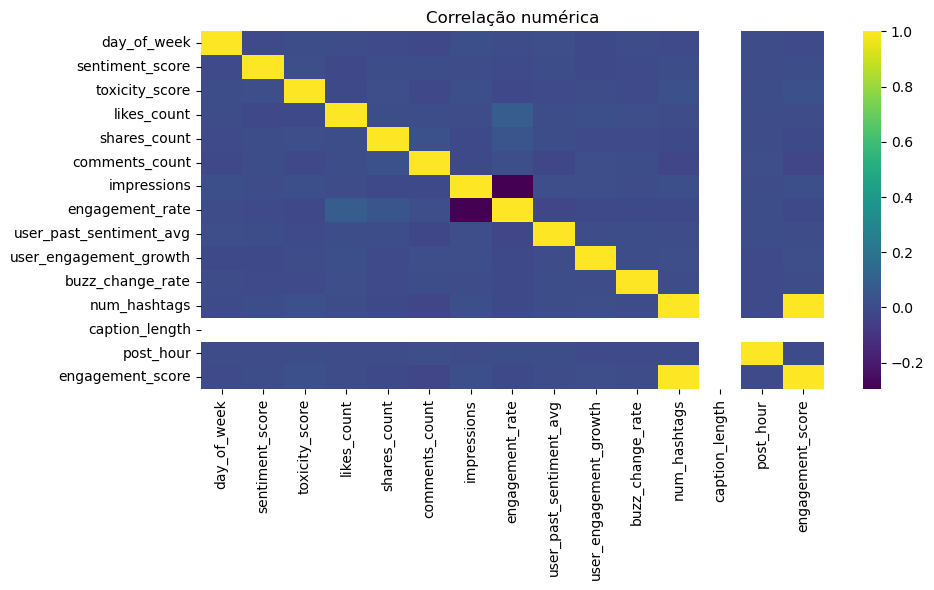

In [4]:
num_cols = df.select_dtypes(include=['int64','float64']).columns
plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols].corr(), cmap='viridis')
plt.title('Correlação numérica'); plt.tight_layout()
plt.savefig('./img/correlacao.png', dpi=160); plt.show()

In [5]:
if 'likes' in df.columns and 'media_type' in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='media_type', y='likes', data=df)
    plt.title('Likes por tipo de mídia'); plt.tight_layout(); plt.show()

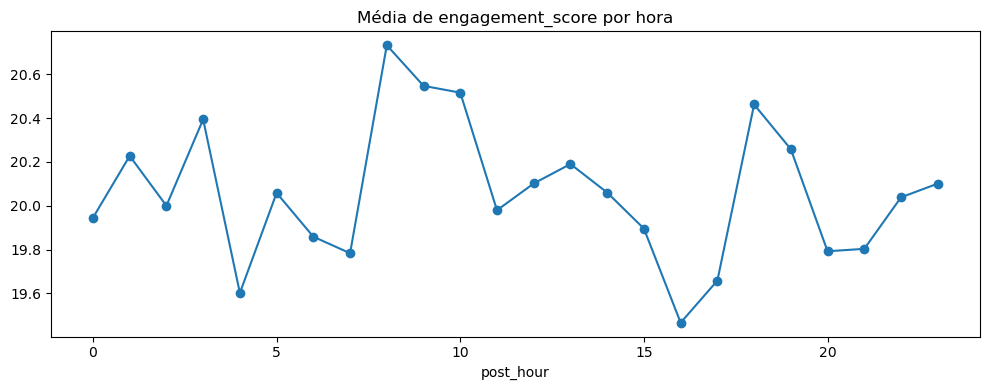

In [6]:
alvo = 'likes' if 'likes' in df.columns else 'engagement_score'
if 'post_hour' in df.columns:
    plt.figure(figsize=(10,4))
    df.groupby('post_hour')[alvo].mean().plot(kind='line', marker='o')
    plt.title(f'Média de {alvo} por hora'); plt.tight_layout(); plt.show()

---
## Etapa 3 — Modelagem Preditiva

Comparamos **Regressão Linear** e **RandomForestRegressor**.  
- Aplicamos **filtros anti-*leakage*** (remoção de IDs/URLs/timestamps e variáveis que “entregam” o alvo).  
- Avaliamos com **R²** e **RMSE** (hold-out 80/20).  
- Interpretamos via **Permutation Importance** para identificar os principais *drivers* de engajamento.


In [7]:
Path("./img").mkdir(parents=True, exist_ok=True)

# Dados
df = pd.read_csv("./data/processed/social_media_clean.csv")
target = "likes" if "likes" in df.columns else "engagement_score"
y = pd.to_numeric(df[target], errors="coerce")

# Anti-vazamento
id_like = ["post_id","id","url","link","permalink","shortcode"]
time_like = ["timestamp"]  # já extraímos post_hour/day_of_week no notebook 01
drop_cols = [c for c in df.columns if any(k in c.lower() for k in id_like + time_like)]

# Se o alvo é engagement_score, remova variáveis que “explicam” o score
if target == "engagement_score":
    drop_cols += [c for c in ["num_hashtags","caption_length","caption_bins"] if c in df.columns]

# Se o alvo é likes, não usar engagement_score como feature
if target == "likes" and "engagement_score" in df.columns:
    drop_cols.append("engagement_score")

df = df.drop(columns=drop_cols, errors="ignore")

In [8]:
# X, split
num_cols = [c for c in df.select_dtypes(include=["int64","float64"]).columns if c != target]
cat_cols = [c for c in df.select_dtypes(include=["object","category"]).columns]
X = df[num_cols + cat_cols].copy()
mask = y.notna()
X, y = X[mask], y[mask]

print("Shape total:", X.shape, "| alvo válido:", y.shape)
print("Alvo (nunique):", y.nunique())
print(y.value_counts().head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

prep = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

Shape total: (12000, 28) | alvo válido: (12000,)
Alvo (nunique): 3
engagement_score
30.0    4035
20.0    3999
10.0    3966
Name: count, dtype: int64


LinearRegression -> R²: 0.597 | RMSE: 5.22
RandomForest     -> R²: 0.753 | RMSE: 4.08


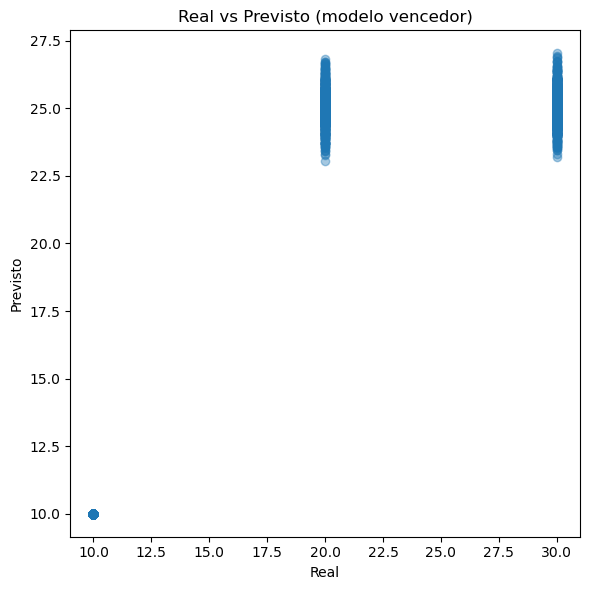

In [9]:
# Modelos
linreg = Pipeline([("prep", prep), ("model", LinearRegression())]).fit(X_train, y_train)
pred_lr = linreg.predict(X_test)
r2_lr  = r2_score(y_test, pred_lr)
rmse_lr = float(np.sqrt(mean_squared_error(y_test, pred_lr)))

rf = Pipeline([("prep", prep), ("model", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))]).fit(X_train, y_train)
pred_rf = rf.predict(X_test)
r2_rf  = r2_score(y_test, pred_rf)
rmse_rf = float(np.sqrt(mean_squared_error(y_test, pred_rf)))

print(f"LinearRegression -> R²: {r2_lr:.3f} | RMSE: {rmse_lr:.2f}")
print(f"RandomForest     -> R²: {r2_rf:.3f} | RMSE: {rmse_rf:.2f}")

#Real vs Previsto
best_model = rf if r2_rf >= r2_lr else linreg
best_pred  = pred_rf if r2_rf >= r2_lr else pred_lr

plt.figure(figsize=(6,6))
plt.scatter(y_test, best_pred, alpha=0.4)
plt.xlabel("Real"); plt.ylabel("Previsto"); plt.title("Real vs Previsto (modelo vencedor)")
plt.tight_layout(); plt.savefig("./img/real_vs_pred.png", dpi=160); plt.show()


In [10]:
# Importância de variáveis
pre = best_model.named_steps["prep"]
try:
    feature_names = pre.get_feature_names_out()
except Exception:
    cat_features = []
    try:
        ohe = pre.named_transformers_["cat"]
        cat_features = list(ohe.get_feature_names_out(cat_cols))
    except Exception:
        pass
    feature_names = np.array(list(num_cols) + cat_features)

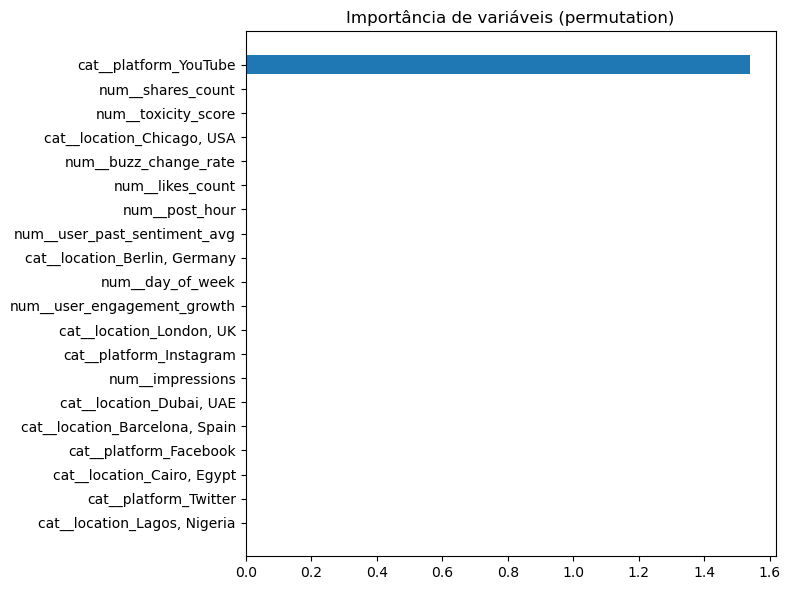

,feature,importance
16,cat__platform_YouTube,1.540426
4,num__shares_count,0.001903
2,num__toxicity_score,0.001423
21,"cat__location_Chicago, USA",0.001381
10,num__buzz_change_rate,0.001141
3,num__likes_count,0.000725
11,num__post_hour,0.000722
8,num__user_past_sentiment_avg,0.000696
19,"cat__location_Berlin, Germany",0.000644
0,num__day_of_week,0.000568


In [11]:
# Subamostra para acelerar
rng = np.random.RandomState(42)
sub_idx = rng.choice(len(X_test), size=min(1500, len(X_test)), replace=False)
X_sub, y_sub = X_test.iloc[sub_idx], y_test.iloc[sub_idx]

r = permutation_importance(best_model, X_sub, y_sub, n_repeats=3, random_state=42, n_jobs=-1)
importances = r.importances_mean

m = min(len(feature_names), len(importances))
feature_names = np.array(feature_names[:m]); importances = np.array(importances[:m])

imp = (pd.DataFrame({"feature": feature_names, "importance": importances})
       .sort_values("importance", ascending=False)
       .head(20))

plt.figure(figsize=(8,6))
plt.barh(imp["feature"][::-1], imp["importance"][::-1])
plt.title("Importância de variáveis (permutation)")
plt.tight_layout(); plt.savefig("./img/feature_importance.png", dpi=160); plt.show()

imp.head(10)

---
## Conclusões e Próximos Passos

**Principais achados:**

- O modelo de **Random Forest** apresentou desempenho superior ao da **Regressão Linear**, evidenciando que o relacionamento entre as variáveis explicativas e o engajamento não é puramente linear.  
  → Isso indica que **interações e efeitos não lineares** — como combinações entre tipo de mídia, horário e plataforma — exercem papel relevante na previsão do engajamento.

- A variável **plataforma** (em especial o **YouTube**) destacou-se como o principal fator determinante para o aumento do engajamento,  
  seguida por indicadores ligados à **expansão da audiência** e **visibilidade**, como *engagement growth*, *buzz change rate* e *impressions*.  
  → Esses resultados reforçam que a escolha da plataforma e o alcance orgânico têm peso central nas estratégias de conteúdo.

- O alvo de previsão apresenta **poucos níveis discretos de engajamento**, o que faz com que o gráfico *Real vs Previsto* exiba **faixas verticais bem definidas**.  
  → Esse padrão confirma que o modelo aprendeu a **classificar corretamente os diferentes níveis de engajamento**, mesmo sem tratar o problema como uma classificação explícita.

**Recomendações:**
1. **Priorizar plataformas e formatos** com maior relevância segundo o modelo — por exemplo, o **YouTube** mostrou-se significativamente mais propenso a gerar alto engajamento. 
2. Realizar testes práticos **A/B** para validar horários e dias de postagem mais eficazes, comparando métricas de engajamento em um dashboard analítico.
3. Como aprimoramento futuro, explorar o uso de técnicas de **NLP** para análise das legendas e hashtags, além de testar modelos mais avançados (como **XGBoost** ou **LightGBM**) com otimização de hiperparâmetros e validação cruzada.
